In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [27]:
import glob
import os
import pickle
import json

import cv2
import numpy as np
import pandas as pd

In [4]:
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score 
from sklearn.metrics import accuracy_score, make_scorer

In [12]:
DATA_DIR = os.path.join('../data')
VEHICLES = os.path.join(DATA_DIR, 'vehicles')
NON_VEHICLES = os.path.join(DATA_DIR, 'non-vehicles')

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

In [8]:
class HogFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, color_scheme, orientation, pixels_per_cell, cells_per_block):
        self.color_scheme = color_scheme
        self.orientation = orientation
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def _hog_feature(self, image):
        return hog(image, orientations=self.orientation, 
                   pixels_per_cell=(self.pixels_per_cell, self.pixels_per_cell), 
                   cells_per_block=(self.cells_per_block, self.cells_per_block), 
                   feature_vector=True)
    
    def fit(self, X, y, **fit_params):
        return self
    
    def transform(self, X):
        X_new = []
        for x in X:
            img = cv2.cvtColor(x, self.color_scheme).astype(np.float32)/255
            # HOG Features
            rhf = self._hog_feature(img[:, :, 0])
            ghf = self._hog_feature(img[:, :, 1])
            bhf = self._hog_feature(img[:, :, 2])
            
            # Histogram Features
            channel1_hist = np.histogram(img[:,:,0], bins=32)
            channel2_hist = np.histogram(img[:,:,1], bins=32)
            channel3_hist = np.histogram(img[:,:,2], bins=32)
            # Concatenate the histograms into a single feature vector
            hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
            
            X_new.append(np.hstack((rhf, ghf, bhf, hist_features)))
        return np.array(X_new)
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, y).transform(X)

In [19]:
def read(data_dir):
    for img_path in glob.iglob(os.path.join(data_dir, '*', '*.png')):
        image = cv2.imread(img_path)
        yield cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [20]:
vehicles = [feature for feature in read(VEHICLES)]

In [21]:
non_vehicles = [feature for feature in read(NON_VEHICLES)]

In [22]:
data = np.vstack((vehicles, non_vehicles))
labels = np.hstack((np.ones(len(vehicles), np.int32), np.zeros(len(non_vehicles), np.int32)))

In [23]:
len(labels) == len(data)

True

In [24]:
data.shape

(17760, 64, 64, 3)

In [25]:
labels.shape

(17760,)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [27]:
x_train.shape

(14208, 64, 64, 3)

In [ ]:
clf = svm.LinearSVC()
scaler = StandardScaler()
extractor = HogFeatureExtractor(cv2.COLOR_BGR2YCrCb, 9, 8, 2)
pipeline = Pipeline([('hog', extractor), ('scaler', scaler), ('svc', clf)])
# pipeline.fit(x_train, y_train)

In [ ]:
color_schemes = [cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HLS, cv2.COLOR_BGR2YCrCb]
orientations = [9, 11, 13]
ppc = [8, 16]
cpb = [2, 3]
param_grid = dict(hog__color_scheme=color_schemes,
                  hog__orientation=orientations, 
                  hog__pixels_per_cell=ppc, 
                  hog__cells_per_block=cpb)

In [ ]:
grid = GridSearchCV(pipeline, param_grid=param_grid, 
                    scoring=make_scorer(f1_score))

In [ ]:
grid.fit(x_train, y_train)

In [ ]:
with open('grid_cv_hist.p', 'wb') as _file:
    pickle.dump(grid, _file)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
results = pd.DataFrame(grid.cv_results_)

In [ ]:
results

In [ ]:
acc = grid.best_estimator_.score(x_test, y_test)

In [ ]:
acc

In [ ]:
pred = grid.best_estimator_.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, pred)

In [ ]:
cm

In [ ]:
with open('classifier_hist.p', 'wb') as _file:
    pickle.dump(grid.best_estimator_, _file)

In [ ]:
grid.best_estimator_

In [29]:
def hog_feature(image, orientations):
    return hog(image, orientations=orientations, 
               pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), 
               feature_vector=True)
    
def feature_extractor(image, orientations):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb).astype(np.float32)/255
    # HOG Features
    rhf = hog_feature(img[:, :, 0], orientations)
    ghf = hog_feature(img[:, :, 1], orientations)
    bhf = hog_feature(img[:, :, 2], orientations)
    return np.hstack((rhf, ghf, bhf))

def feature_extractor_w_hist(image, orientations):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb).astype(np.float32)/255
    # HOG Features
    rhf = hog_feature(img[:, :, 0], orientations)
    ghf = hog_feature(img[:, :, 1], orientations)
    bhf = hog_feature(img[:, :, 2], orientations)
    # Histogram Features
    channel1_hist = np.histogram(img[:,:,0], bins=32)
    channel2_hist = np.histogram(img[:,:,1], bins=32)
    channel3_hist = np.histogram(img[:,:,2], bins=32)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return np.hstack((rhf, ghf, bhf, hist_features))
            

In [30]:
x_feat1 = [feature_extractor(x, 13) for x in x_train]
x_test_feat1 = [feature_extractor(x, 13) for x in x_test]

pipe1 = Pipeline([('scaler', StandardScaler()), ('svc', svm.LinearSVC())])
pipe1.fit(x_feat1, y_train)

pred = pipe1.predict(x_test_feat1)
cm = confusion_matrix(pred, y_test)
acc = accuracy_score(pred, y_test)
f1 = f1_score(pred, y_test)
print(acc, cm, f1)

0.990146396396 [[1806   20]
 [  15 1711]] 0.989875614695


In [31]:
x_feat2 = [feature_extractor_w_hist(x, 13) for x in x_train]
x_test_feat2 = [feature_extractor_w_hist(x, 13) for x in x_test]

pipe2 = Pipeline([('scaler', StandardScaler()), ('svc', svm.LinearSVC())])
pipe2.fit(x_feat2, y_train)

pred = pipe2.predict(x_test_feat2)
cm = confusion_matrix(pred, y_test)
acc = accuracy_score(pred, y_test)
f1 = f1_score(pred, y_test)
print(acc, cm, f1)

0.99268018018 [[1810   15]
 [  11 1716]] 0.992481203008


In [32]:
x_feat3 = [feature_extractor(x, 9) for x in x_train]
x_test_feat3 = [feature_extractor(x, 9) for x in x_test]

pipe3 = Pipeline([('scaler', StandardScaler()), ('svc', svm.LinearSVC())])
pipe3.fit(x_feat3, y_train)

pred = pipe3.predict(x_test_feat3)
cm = confusion_matrix(pred, y_test)
acc = accuracy_score(pred, y_test)
f1 = f1_score(pred, y_test)
print(acc, cm, f1)

0.989301801802 [[1802   19]
 [  19 1712]] 0.989023685731


In [33]:
x_feat4 = [feature_extractor_w_hist(x, 9) for x in x_train]
x_test_feat4 = [feature_extractor_w_hist(x, 9) for x in x_test]

pipe4 = Pipeline([('scaler', StandardScaler()), ('svc', svm.LinearSVC())])
pipe4.fit(x_feat4, y_train)

pred = pipe4.predict(x_test_feat4)
cm = confusion_matrix(pred, y_test)
acc = accuracy_score(pred, y_test)
f1 = f1_score(pred, y_test)
print(acc, cm, f1)

0.99268018018 [[1808   13]
 [  13 1718]] 0.992489890237


In [34]:
classifiers = {
    'pipe1': pipe1,
    'pipe2': pipe2,
    'pipe3': pipe3,
    'pipe4': pipe4
}

with open('classifier.p', 'wb') as _file:
    pickle.dump(classifiers, _file)

In [9]:
with open('grid_cv_hist.p', 'rb') as _file:
    grid = pickle.load(_file)

In [10]:
grid.best_params_

{'hog__cells_per_block': 2,
 'hog__color_scheme': 36,
 'hog__orientation': 13,
 'hog__pixels_per_cell': 8}

In [11]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('hog', HogFeatureExtractor(cells_per_block=2, color_scheme=36, orientation=13,
          pixels_per_cell=8)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [25]:
from sklearn.utils import shuffle
vehicle_images = shuffle([i for i in glob.iglob(os.path.join(NON_VEHICLES, '*', '*.png'))])

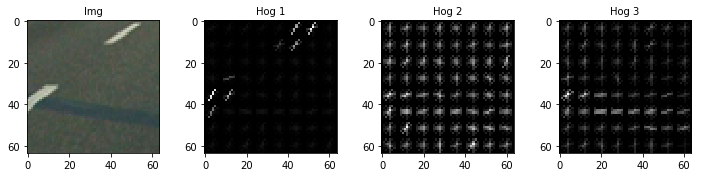

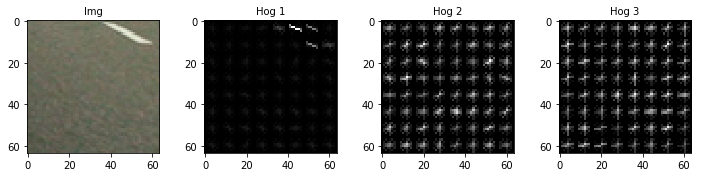

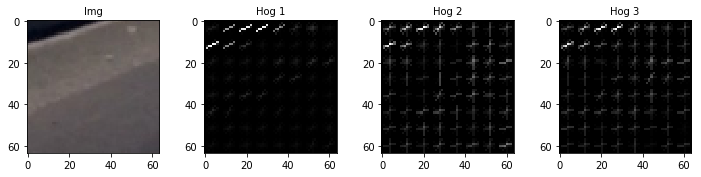

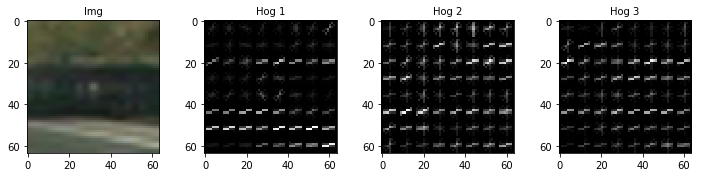

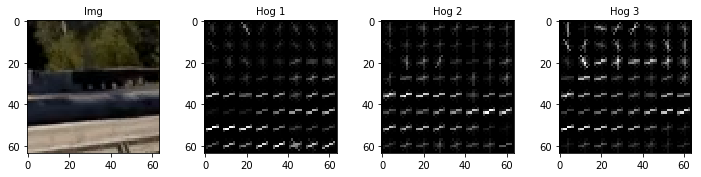

In [26]:
def hog_feature(image):
    return hog(image, orientations=9, 
               pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), 
               feature_vector=True, visualise=True)

for image_path in vehicle_images[:5]:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    _, hog1 = hog_feature(ycrcb[:, :, 0])
    _, hog2 = hog_feature(ycrcb[:, :, 1])
    _, hog3 = hog_feature(ycrcb[:, :, 2])
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 10))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Img', fontsize=10)
    ax2.imshow(hog1, cmap='gray')
    ax2.set_title('Hog 1', fontsize=10)
    ax3.imshow(hog2, cmap='gray')
    ax3.set_title('Hog 2', fontsize=10)
    ax4.imshow(hog3, cmap='gray')
    ax4.set_title('Hog 3', fontsize=10)

In [28]:
grid_hist_pd = pd.DataFrame(grid.cv_results_)

In [29]:
grid_hist_pd

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_hog__cells_per_block,param_hog__color_scheme,param_hog__orientation,param_hog__pixels_per_cell,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,66.335829,23.505637,0.976151,1.000000,2,4,9,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",26,0.975631,1.000000,0.976058,1.000000,0.976764,1.000000,3.618995,1.038284,0.000467,0.000000
1,32.127077,15.349342,0.969840,0.999540,2,4,9,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",33,0.968314,0.999788,0.972010,0.999576,0.969195,0.999258,0.262920,0.856850,0.001576,0.000218
2,75.356264,26.813124,0.974732,1.000000,2,4,11,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",29,0.972074,1.000000,0.974675,1.000000,0.977447,1.000000,3.692100,0.323568,0.002194,0.000000
3,33.865262,16.088247,0.972904,0.999717,2,4,11,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",32,0.971792,0.999682,0.973203,0.999470,0.973718,1.000000,1.075577,1.441640,0.000814,0.000218
4,81.255457,26.261958,0.976717,1.000000,2,4,13,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",25,0.977181,1.000000,0.975891,1.000000,0.977080,1.000000,4.981679,1.616481,0.000586,0.000000
5,36.641641,15.542252,0.974696,0.999965,2,4,13,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",31,0.973891,1.000000,0.976024,1.000000,0.974174,0.999894,1.489835,0.958747,0.000946,0.000050
6,60.745514,26.099978,0.988252,1.000000,2,52,9,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",13,0.985993,1.000000,0.988530,1.000000,0.990234,1.000000,5.912787,1.722663,0.001742,0.000000
7,35.604699,15.698892,0.985893,1.000000,2,52,9,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",21,0.984954,1.000000,0.986475,1.000000,0.986249,1.000000,2.350016,0.884452,0.000670,0.000000
8,63.713528,23.782884,0.988455,1.000000,2,52,11,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",12,0.987896,1.000000,0.987875,1.000000,0.989594,1.000000,2.268968,1.674660,0.000806,0.000000
9,30.375950,14.152921,0.987495,1.000000,2,52,11,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",16,0.986644,1.000000,0.988151,1.000000,0.987691,1.000000,0.216579,0.114652,0.000630,0.000000


In [30]:
with open('grid_cv.p', 'rb') as _file:
    grid = pickle.load(_file)

In [31]:
grid_pd = pd.DataFrame(grid.cv_results_)

In [32]:
grid_pd

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_hog__cells_per_block,param_hog__color_scheme,param_hog__orientation,param_hog__pixels_per_cell,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,62.176049,20.471302,0.963889,1.000000,2,4,9,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",28,0.964721,1.000000,0.960526,1.000000,0.966420,1.000000,4.174857,2.012092,0.002477,0.000000
1,26.473876,11.889537,0.954056,0.998134,2,4,9,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",33,0.953761,0.998416,0.953326,0.998522,0.955080,0.997465,1.245189,0.424366,0.000746,0.000475
2,69.445746,20.699661,0.966355,1.000000,2,4,11,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",24,0.964606,1.000000,0.969581,1.000000,0.964879,1.000000,4.608525,0.125499,0.002284,0.000000
3,27.570767,11.497787,0.955341,0.999261,2,4,11,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",32,0.951390,0.999472,0.955054,0.999261,0.959579,0.999050,0.531900,0.146240,0.003349,0.000172
4,73.622381,21.452239,0.966127,1.000000,2,4,13,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",25,0.967687,1.000000,0.964202,1.000000,0.966491,1.000000,0.468471,0.292642,0.001446,0.000000
5,28.284447,11.943167,0.959135,0.999648,2,4,13,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",31,0.958875,0.999366,0.956815,0.999894,0.961716,0.999683,0.223156,0.197195,0.002010,0.000217
6,47.145064,18.036004,0.982921,1.000000,2,52,9,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",12,0.983000,1.000000,0.983953,1.000000,0.981810,1.000000,3.923475,0.100413,0.000876,0.000000
7,21.745818,10.011371,0.971237,0.999965,2,52,9,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",21,0.966519,1.000000,0.973855,0.999894,0.973336,1.000000,0.262681,0.081042,0.003342,0.000050
8,41.032850,18.546799,0.982438,1.000000,2,52,11,8,"{'hog__pixels_per_cell': 8, 'hog__cells_per_bl...",14,0.979427,1.000000,0.985862,1.000000,0.982026,1.000000,0.181101,0.109530,0.002643,0.000000
9,22.976230,10.519795,0.973128,0.999930,2,52,11,16,"{'hog__pixels_per_cell': 16, 'hog__cells_per_b...",20,0.970272,0.999894,0.973822,1.000000,0.975290,0.999894,0.200215,0.107686,0.002107,0.000050


In [33]:
grid_pd.columns

Index(['mean_fit_time', 'mean_score_time', 'mean_test_score',
       'mean_train_score', 'param_hog__cells_per_block',
       'param_hog__color_scheme', 'param_hog__orientation',
       'param_hog__pixels_per_cell', 'params', 'rank_test_score',
       'split0_test_score', 'split0_train_score', 'split1_test_score',
       'split1_train_score', 'split2_test_score', 'split2_train_score',
       'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score'],
      dtype='object')

In [41]:
columns = ['mean_test_score',
       'mean_train_score', 'param_hog__cells_per_block',
       'param_hog__color_scheme', 'param_hog__orientation',
       'param_hog__pixels_per_cell']

In [42]:
join_columns = ['param_hog__cells_per_block',
       'param_hog__color_scheme', 'param_hog__orientation',
       'param_hog__pixels_per_cell']

In [43]:
gh_cv = grid_hist_pd[columns]
g_cv = grid_pd[columns]

In [44]:
merged = pd.merge(g_cv, gh_cv, how='inner', on=join_columns)

In [45]:
merged

,mean_test_score_x,mean_train_score_x,param_hog__cells_per_block,param_hog__color_scheme,param_hog__orientation,param_hog__pixels_per_cell,mean_test_score_y,mean_train_score_y
0,0.963889,1.000000,2,4,9,8,0.976151,1.000000
1,0.954056,0.998134,2,4,9,16,0.969840,0.999540
2,0.966355,1.000000,2,4,11,8,0.974732,1.000000
3,0.955341,0.999261,2,4,11,16,0.972904,0.999717
4,0.966127,1.000000,2,4,13,8,0.976717,1.000000
5,0.959135,0.999648,2,4,13,16,0.974696,0.999965
6,0.982921,1.000000,2,52,9,8,0.988252,1.000000
7,0.971237,0.999965,2,52,9,16,0.985893,1.000000
8,0.982438,1.000000,2,52,11,8,0.988455,1.000000
9,0.973128,0.999930,2,52,11,16,0.987495,1.000000


In [46]:
merged.rename(index=str, columns={"mean_test_score_y": "f1_test_hog_w_hist", 
                              "mean_test_score_x": "f1_test_hog",
                              "mean_train_score_y": "f1_train_hog_w_hist",
                              "mean_train_score_x": "f1_train_hog"
                             })

,f1_test_hog,f1_train_hog,param_hog__cells_per_block,param_hog__color_scheme,param_hog__orientation,param_hog__pixels_per_cell,f1_test_hog_w_hist,f1_train_hog_w_hist
0,0.963889,1.000000,2,4,9,8,0.976151,1.000000
1,0.954056,0.998134,2,4,9,16,0.969840,0.999540
2,0.966355,1.000000,2,4,11,8,0.974732,1.000000
3,0.955341,0.999261,2,4,11,16,0.972904,0.999717
4,0.966127,1.000000,2,4,13,8,0.976717,1.000000
5,0.959135,0.999648,2,4,13,16,0.974696,0.999965
6,0.982921,1.000000,2,52,9,8,0.988252,1.000000
7,0.971237,0.999965,2,52,9,16,0.985893,1.000000
8,0.982438,1.000000,2,52,11,8,0.988455,1.000000
9,0.973128,0.999930,2,52,11,16,0.987495,1.000000
